# Defect Detection Strategy Testing

We will test two strategies to speed up inference on large images (20MP):
1. **Direct Inference**: Running on the full image with increased input size.
2. **Optimized Tiling**: Using larger patch sizes (e.g., 1024x1024) to drastically reduce the number of patches.

## 1. Setup

In [1]:
!uv add ultralytics ipywidgets matplotlib opencv-python

Resolved 109 packages in 809ms                                       
Uninstalled 2 packages in 47ms
Installed 3 packages in 67ms                                
 - numpy==2.2.6
 + numpy==2.3.5
 - opencv-python==4.12.0.88
 + opencv-python==4.11.0.86
 + opencv-python-headless==4.11.0.86


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import time

# Set images directory
IMAGES_DIR = '/home/dmore/code/TFM_David/CNN_Galicia_Toshiba/datasets/galicia_segmentation/images/train'
image_name = "imagenes_galicia_1.jpg" # Ensure this exists
image_path = os.path.join(IMAGES_DIR, image_name)

print(f"Target Image: {image_path}")

Target Image: /home/dmore/code/TFM_David/CNN_Galicia_Toshiba/datasets/galicia_segmentation/images/train/imagenes_galicia_1.jpg


## 2. Load the Model

In [3]:
try:
    model = YOLO("yolo11s.pt") 
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

Model loaded successfully.


## 3. Strategy A: Direct Inference (Fastest)
We try to feed the whole image. We increase `imgsz` (default is 640) to help detect smaller objects without full tiling. 
Try `imgsz=1280` or `imgsz=1600`. Caution: Higher values consume more VRAM.

Running Direct Inference...

image 1/1 /home/dmore/code/TFM_David/CNN_Galicia_Toshiba/datasets/galicia_segmentation/images/train/imagenes_galicia_1.jpg: 864x1280 8 birds, 170.4ms
Speed: 6.6ms preprocess, 170.4ms inference, 4.1ms postprocess per image at shape (1, 3, 864, 1280)
Inference took: 0.33 seconds


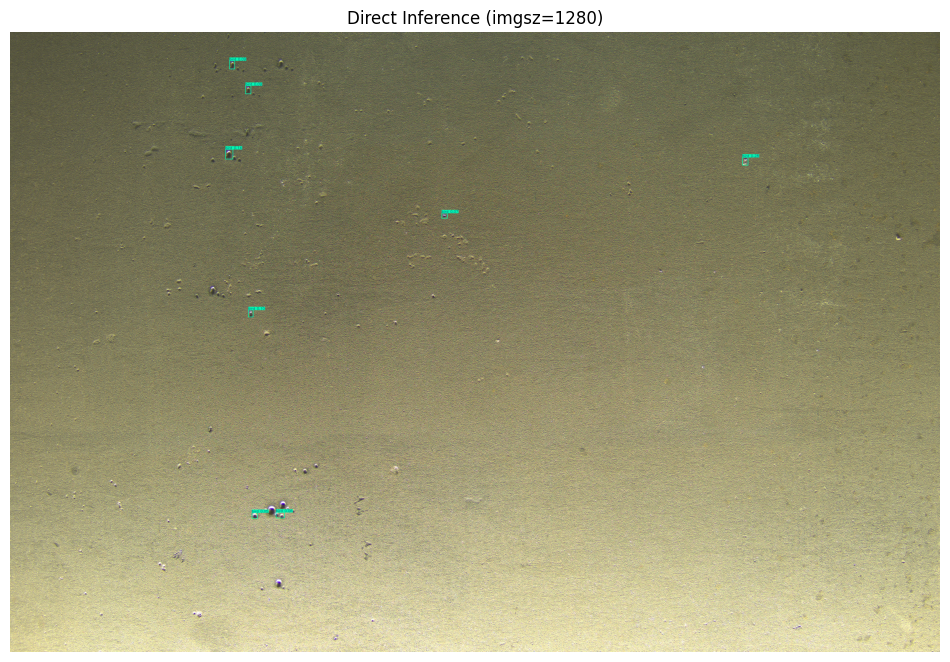

In [17]:
if os.path.exists(image_path):
    print("Running Direct Inference...")
    start_time = time.time()
    
    # imgsz=1280 allows the model to see more detail than standard 640
    results = model.predict(image_path, imgsz=1280, conf=0.05, verbose=True) 
    
    end_time = time.time()
    print(f"Inference took: {end_time - start_time:.2f} seconds")
    
    # Visualize
    result = results[0]
    res_plotted = result.plot(conf=True, boxes=True, line_width=2)
    res_rgb = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 12))
    plt.imshow(res_rgb)
    plt.axis('off')
    plt.title(f"Direct Inference (imgsz=1280)")
    plt.show()
    
    if len(result.boxes) == 0:
        print("No detections found with Direct Inference.")
else:
    print("Image not found.")

## 4. Strategy B: Optimized Tiling (Larger Patches)
If direct inference misses small defects, we use tiling but with **much larger patches** (e.g., 1024x1024 instead of 224x224) to reduce the count from ~400 to ~25.

Original Image Shape: (3648, 5472, 3)
Generated 24 patches of size ~1024x1024

>>> Detection on Patch 1 at (0, 1024)


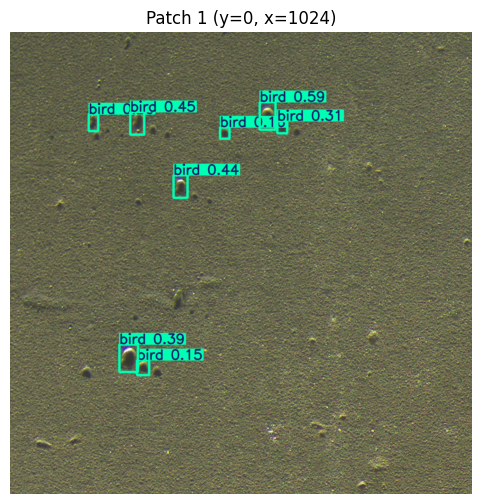


>>> Detection on Patch 7 at (1024, 1024)


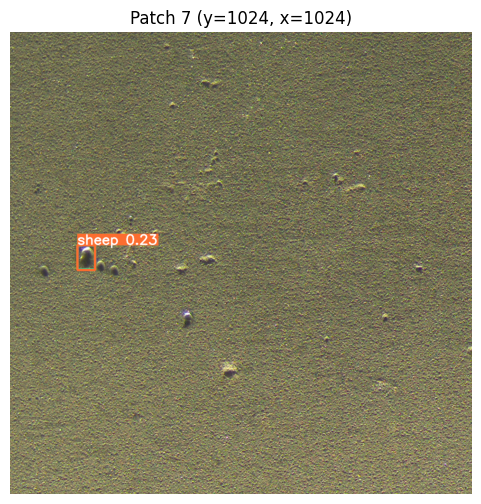


>>> Detection on Patch 13 at (2048, 1024)


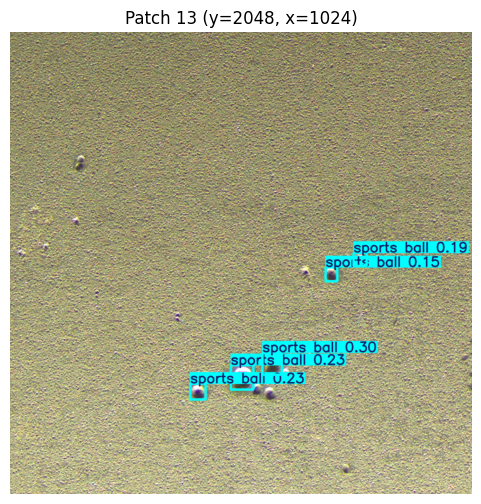


>>> Detection on Patch 19 at (3072, 1024)


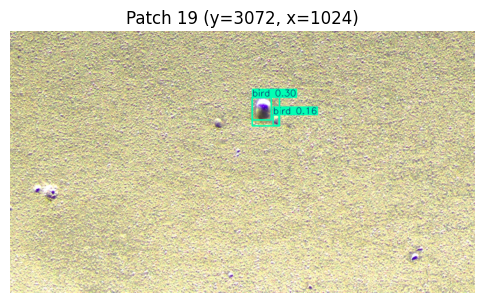

In [18]:
def extract_patches(image, patch_size, overlap=0):
    img_h, img_w = image.shape[:2]
    patches = []
    coords = [] 
    
    stride = patch_size - overlap
    
    for y in range(0, img_h, stride):
        for x in range(0, img_w, stride):
            y_end = min(y + patch_size, img_h)
            x_end = min(x + patch_size, img_w)
            
            patch = image[y:y_end, x:x_end]
            
            # Optional: Pad patch if it's smaller than patch_size at edges
            # For simplicity, we just infer on the crop
            
            patches.append(patch)
            coords.append((y, x))
            
    return patches, coords

PATCH_SIZE = 1024

img = cv2.imread(image_path)
if img is not None:
    print(f"Original Image Shape: {img.shape}")
    patches, coords = extract_patches(img, PATCH_SIZE, overlap=0)
    print(f"Generated {len(patches)} patches of size ~{PATCH_SIZE}x{PATCH_SIZE}")
    
    # Inference on patches
    detections_found = False
    
    for i, patch in enumerate(patches):
        # Running inference on patch
        # Since patch is 1024, default imgsz=640 results in some downscaling, 
        # but much less severe than full image. 
        # You can set imgsz=1024 for 1:1, but it might be slower.
        results = model.predict(patch, conf=0.15, verbose=False, imgsz=640)
        result = results[0]
        
        if len(result.boxes) > 0:
            detections_found = True
            print(f"\n>>> Detection on Patch {i} at {coords[i]}")
            res_plotted = result.plot(conf=True, boxes=True)
            res_rgb = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)
            
            plt.figure(figsize=(6, 6))
            plt.imshow(res_rgb)
            plt.axis('off')
            plt.title(f"Patch {i} (y={coords[i][0]}, x={coords[i][1]})")
            plt.show()
            
    if not detections_found:
        print("No detections found in any patch.")